In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DemographicSparkMiniProject').getOrCreate()

In [4]:
df = spark.read.csv("Demographic_update_data_March-July.csv", header=True)
df.show()
df.printSchema()

+----------+--------------+----------------+-------+-------------+------------+
|      Date|         State|        District|Pincode|Demo_age_5_17|Demo_age_17+|
+----------+--------------+----------------+-------+-------------+------------+
|01-03-2025|  Chhattisgarh|         Surguja| 497101|          104|        1470|
|01-03-2025|     Rajasthan|       Bharatpur| 321303|           94|        1450|
|01-03-2025| Uttar Pradesh|       Sonbhadra| 231225|           43|         666|
|01-03-2025|     Rajasthan|          Nagaur| 341001|          349|        6894|
|01-03-2025|Andhra Pradesh|   East Godavari| 533254|           11|         143|
|01-03-2025|         Bihar|           Jamui| 811312|           92|        1215|
|01-03-2025|         Bihar|         Katihar| 855114|          113|        1607|
|01-03-2025| Uttar Pradesh|        Bahraich| 271824|           59|         956|
|01-03-2025|Madhya Pradesh|           Seoni| 480888|           74|        1816|
|01-03-2025|         Bihar|        Vaish

#### HANDLING NULL VALUES

In [5]:
numeric_cols = ['Pincode','Demo_age_5_17','Demo_age_17+']
from pyspark.sql.functions import when, col
for c in numeric_cols:
    df = df.withColumn(c, when(col(c).isNull(), 0).otherwise(col(c)))

for c in numeric_cols:
    print(c, df.filter(col(c).isNull()).count())

Pincode 0
Demo_age_5_17 0
Demo_age_17+ 0


#### PARSE DATE AND EXTRACT MONTH/YEAR

In [6]:
from pyspark.sql.functions import to_date, month, year

df = df.withColumn('Date_parsed', to_date(col('Date'), 'dd-MM-yyyy'))
df = df.withColumn('Month', month(col('Date_parsed'))).withColumn('Year', year(col('Date_parsed')))
df.select('Date','Date_parsed','Month','Year').show(5,truncate=False)

+----------+-----------+-----+----+
|Date      |Date_parsed|Month|Year|
+----------+-----------+-----+----+
|01-03-2025|2025-03-01 |3    |2025|
|01-03-2025|2025-03-01 |3    |2025|
|01-03-2025|2025-03-01 |3    |2025|
|01-03-2025|2025-03-01 |3    |2025|
|01-03-2025|2025-03-01 |3    |2025|
+----------+-----------+-----+----+
only showing top 5 rows


#### AGGREGATIONS BY STATE AND MONTH

In [7]:
from pyspark.sql.functions import sum as _sum
agg_state_month = df.groupBy('State','Year','Month').agg(_sum('Demo_age_5_17').alias('sum_age_5_17'), _sum('Demo_age_17+').alias('sum_age_17_plus')).orderBy('State','Year','Month')
agg_state_month.show(10,truncate=False)

+---------------------------+----+-----+------------+---------------+
|State                      |Year|Month|sum_age_5_17|sum_age_17_plus|
+---------------------------+----+-----+------------+---------------+
|Andaman and Nicobar Islands|2025|3    |114         |895            |
|Andaman and Nicobar Islands|2025|7    |20          |199            |
|Andhra Pradesh             |2025|3    |41609       |399216         |
|Andhra Pradesh             |2025|4    |6992        |42036          |
|Andhra Pradesh             |2025|5    |22207       |119344         |
|Andhra Pradesh             |2025|6    |20241       |93951          |
|Andhra Pradesh             |2025|7    |10555       |62049          |
|Arunachal Pradesh          |2025|3    |860         |7342           |
|Assam                      |2025|3    |14719       |163079         |
|Assam                      |2025|4    |645         |5214           |
+---------------------------+----+-----+------------+---------------+
only showing top 10 

#### CALCULATE TOTALS, PERCENTAGES AND MOM GROWTH

In [8]:
from pyspark.sql.functions import round as _round
agg_state_month = agg_state_month.withColumn('total_population', col('sum_age_5_17') + col('sum_age_17_plus'))
agg_state_month = agg_state_month.withColumn('pct_age_5_17', _round((col('sum_age_5_17')/col('total_population'))*100,2))

from pyspark.sql.window import Window
from pyspark.sql.functions import lag
w = Window.partitionBy('State').orderBy('Year','Month')
agg_state_month = agg_state_month.withColumn('prev_total', lag('total_population').over(w))
agg_state_month = agg_state_month.withColumn('mon_growth_pct', _round(((col('total_population') - col('prev_total'))/col('prev_total')*100),2))
agg_state_month = agg_state_month.fillna({'mon_growth_pct':0.0, 'prev_total':0})

agg_state_month.show(20,truncate=False)

+---------------------------+----+-----+------------+---------------+----------------+------------+----------+--------------+
|State                      |Year|Month|sum_age_5_17|sum_age_17_plus|total_population|pct_age_5_17|prev_total|mon_growth_pct|
+---------------------------+----+-----+------------+---------------+----------------+------------+----------+--------------+
|Andaman and Nicobar Islands|2025|3    |114         |895            |1009            |11.3        |0         |0.0           |
|Andaman and Nicobar Islands|2025|7    |20          |199            |219             |9.13        |1009      |-78.3         |
|Andhra Pradesh             |2025|3    |41609       |399216         |440825          |9.44        |0         |0.0           |
|Andhra Pradesh             |2025|4    |6992        |42036          |49028           |14.26       |440825    |-88.88        |
|Andhra Pradesh             |2025|5    |22207       |119344         |141551          |15.69       |49028     |188.71  

#### TOP STATES BY YOUTH SHARE (LATEST MONTH)

In [9]:
latest_row = agg_state_month.select('Year','Month').orderBy(col('Year').desc(), col('Month').desc()).first()
if latest_row:
    latest_year, latest_month = latest_row['Year'], latest_row['Month']
    display_df = agg_state_month.filter((col('Year')==latest_year)&(col('Month')==latest_month)).orderBy(col('pct_age_5_17').desc())
    display_df.show(15,truncate=False)
else:
    print('No rows in aggregated dataframe')

+-----------------+----+-----+------------+---------------+----------------+------------+----------+--------------+
|State            |Year|Month|sum_age_5_17|sum_age_17_plus|total_population|pct_age_5_17|prev_total|mon_growth_pct|
+-----------------+----+-----+------------+---------------+----------------+------------+----------+--------------+
|Madhya Pradesh   |2025|7    |53374       |221634         |275008          |19.41       |206837    |32.96         |
|Chandigarh       |2025|7    |1514        |6772           |8286            |18.27       |5976      |38.65         |
|Delhi            |2025|7    |24885       |132061         |156946          |15.86       |110542    |41.98         |
|Karnataka        |2025|7    |10848       |61973          |72821           |14.9        |91251     |-20.2         |
|Jammu and Kashmir|2025|7    |3829        |22009          |25838           |14.82       |16037     |61.11         |
|Andhra Pradesh   |2025|7    |10555       |62049          |72604        

In [13]:
df.show()
df.printSchema()

+----------+--------------+----------------+-------+-------------+------------+-----------+-----+----+
|      Date|         State|        District|Pincode|Demo_age_5_17|Demo_age_17+|Date_parsed|Month|Year|
+----------+--------------+----------------+-------+-------------+------------+-----------+-----+----+
|01-03-2025|  Chhattisgarh|         Surguja| 497101|          104|        1470| 2025-03-01|    3|2025|
|01-03-2025|     Rajasthan|       Bharatpur| 321303|           94|        1450| 2025-03-01|    3|2025|
|01-03-2025| Uttar Pradesh|       Sonbhadra| 231225|           43|         666| 2025-03-01|    3|2025|
|01-03-2025|     Rajasthan|          Nagaur| 341001|          349|        6894| 2025-03-01|    3|2025|
|01-03-2025|Andhra Pradesh|   East Godavari| 533254|           11|         143| 2025-03-01|    3|2025|
|01-03-2025|         Bihar|           Jamui| 811312|           92|        1215| 2025-03-01|    3|2025|
|01-03-2025|         Bihar|         Katihar| 855114|          113|       

#### COUNT OF COLUMN VALUES

In [14]:
df.groupBy("State").count().show()

+--------------------+-----+
|               State|count|
+--------------------+-----+
|            Nagaland|   21|
|           Karnataka| 1900|
|              Odisha|  858|
|              Kerala|  451|
|              Ladakh|   11|
|Dadra and Nagar H...|    4|
|          Tamil Nadu| 1456|
|        Chhattisgarh|  557|
|      Andhra Pradesh| 1999|
|      Madhya Pradesh| 1665|
|              Punjab|  403|
|             Manipur|   67|
|                 Goa|   43|
|             Mizoram|   54|
|Dadra and Nagar H...|    2|
|    Himachal Pradesh|  176|
|          Puducherry|   23|
|             Haryana|  706|
|   Jammu and Kashmir|  355|
|           Jharkhand|  333|
+--------------------+-----+
only showing top 20 rows


In [15]:
df.groupBy("District").count().show()

+---------------+-----+
|       District|count|
+---------------+-----+
|         Kathua|   21|
|      Bangalore|   42|
|      Ganderbal|   13|
|          Lohit|    2|
|        Raichur|   45|
|        Udaipur|   47|
|       Surajpur|   10|
|          Baksa|   14|
|West Garo Hills|    8|
|  East Godavari|  120|
|   Mahendragarh|   23|
|     Bara Banki|   40|
|        Saharsa|   15|
|        Khandwa|   21|
|        Dimapur|    5|
|         Yadgir|   30|
|          Bhind|   23|
|      Kalahandi|   24|
|        Darrang|   13|
|      Singrauli|   22|
+---------------+-----+
only showing top 20 rows


In [16]:
data.groupBy("Pincode").count().show()

+-------+-----+
|Pincode|count|
+-------+-----+
| 140124|    1|
| 400075|    1|
| 679330|    1|
| 274202|    1|
| 577511|    1|
| 580007|    2|
| 841415|    1|
| 241126|    1|
| 761015|    1|
| 700024|    1|
| 816110|    1|
| 522318|    1|
| 761108|    1|
| 276129|    2|
| 110071|    3|
| 471105|    1|
| 577204|    3|
| 848127|    1|
| 576112|    1|
| 768030|    1|
+-------+-----+
only showing top 20 rows


In [17]:
df.groupBy("Demo_age_5_17").count().show()

+-------------+-----+
|Demo_age_5_17|count|
+-------------+-----+
|           29|  234|
|           26|  248|
|          474|    1|
|          191|   24|
|           65|   92|
|          558|    1|
|          418|    1|
|          222|   11|
|          270|    4|
|          293|    2|
|          730|    1|
|          243|   13|
|          278|    6|
|          442|    2|
|          705|    1|
|           19|  349|
|           54|  143|
|          296|    8|
|          287|    7|
|          277|   11|
+-------------+-----+
only showing top 20 rows


In [18]:
df.groupBy("Demo_age_17+").count().show()

+------------+-----+
|Demo_age_17+|count|
+------------+-----+
|          29|    9|
|         474|   18|
|         964|    3|
|        1697|    3|
|        1677|    1|
|          26|    5|
|        1806|    2|
|        2250|    2|
|        2509|    1|
|        1950|    3|
|        2529|    1|
|        2040|    2|
|         558|   23|
|         191|   41|
|         541|    9|
|          65|   21|
|         418|   17|
|        3061|    1|
|        1277|    4|
|        1224|    4|
+------------+-----+
only showing top 20 rows


#### PLOTS

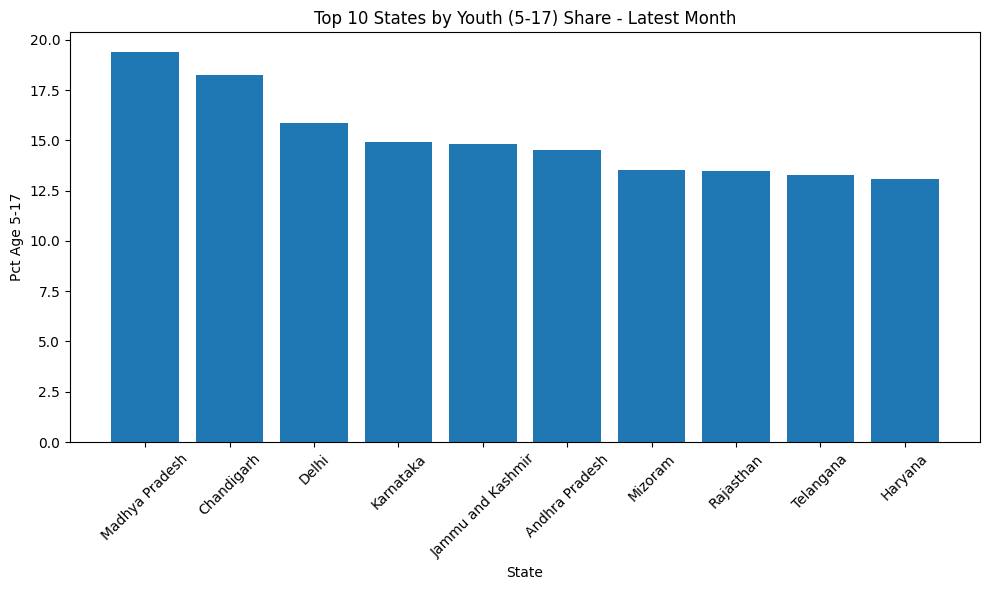

In [19]:
pandas_df = display_df.limit(10).toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(pandas_df['State'], pandas_df['pct_age_5_17'])
plt.title('Top 10 States by Youth (5-17) Share - Latest Month')
plt.xlabel('State')
plt.ylabel('Pct Age 5-17')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observation: For the latest month (July 2025), Madhya Pradesh has the highest share of its population in the 5-17 age group, at nearly 20%. The youth share among the top states varies significantly, from over 18% in Chandigarh down to around 13% for states like Telangana and Haryana, indicating different demographic structures across the country.

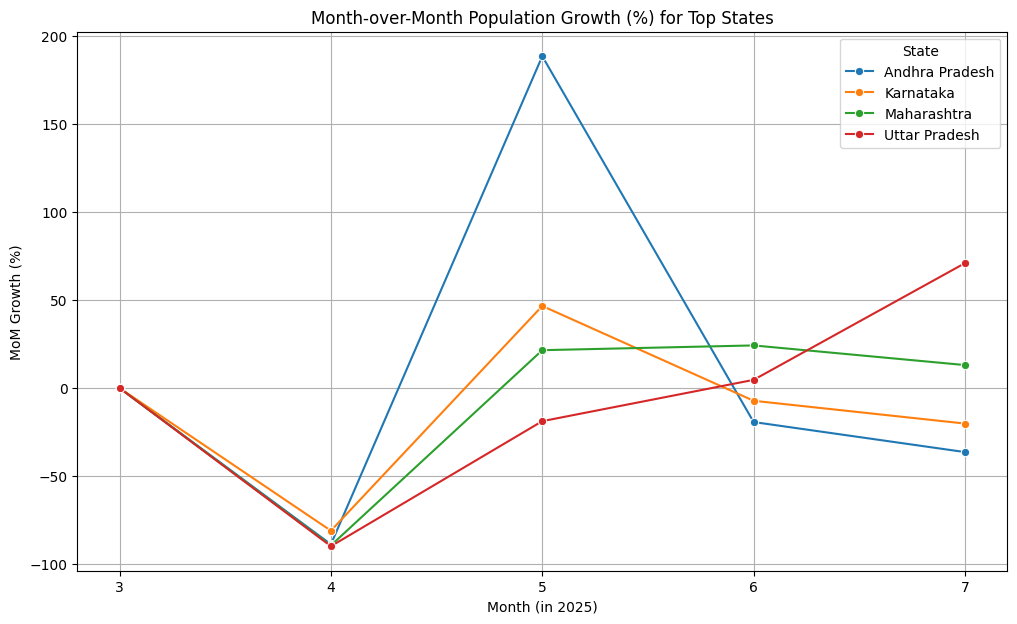

In [20]:
top_states_df = agg_state_month.filter(col('State').isin('Uttar Pradesh', 'Maharashtra', 'Andhra Pradesh', 'Karnataka'))
pandas_growth_df = top_states_df.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
sns.lineplot(data=pandas_growth_df, x='Month', y='mon_growth_pct', hue='State', marker='o')
plt.title('Month-over-Month Population Growth (%) for Top States')
plt.xlabel('Month (in 2025)')
plt.ylabel('MoM Growth (%)')
plt.grid(True)
plt.legend(title='State')
plt.xticks(sorted(pandas_growth_df['Month'].unique())) # Ensure all months are shown
plt.show()

Observation: All four states experienced a significant negative growth (a sharp population drop) between March and April 2025. After this dip, growth patterns diverged. While Maharashtra and Uttar Pradesh showed a more stable and slightly positive trend, Karnataka and Andhra Pradesh continued to decline. The drastic, uniform drop in April across these major states is the most prominent feature, suggesting a widespread event or a potential data anomaly for that month.

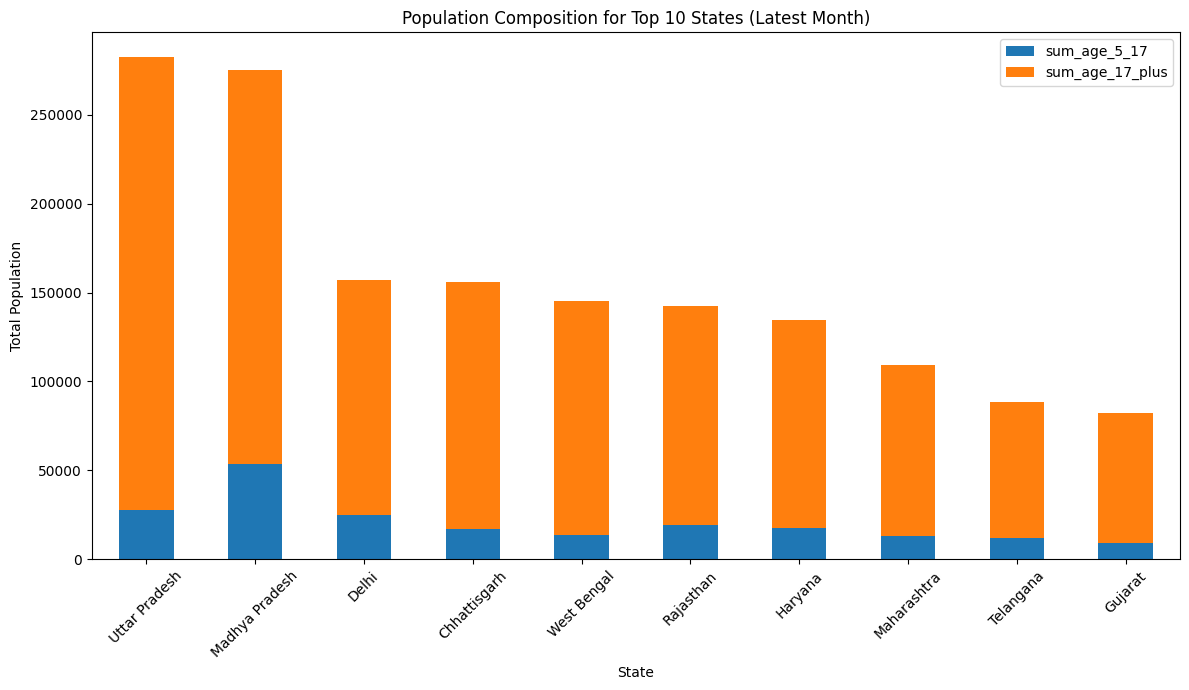

In [21]:
latest_month_df = agg_state_month.filter((col('Year')==latest_year) & (col('Month')==latest_month))
top_10_population_df = latest_month_df.orderBy(col('total_population').desc()).limit(10)

pandas_top10_pop_df = top_10_population_df.toPandas()

pandas_top10_pop_df.plot(
    x='State',
    y=['sum_age_5_17', 'sum_age_17_plus'],
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    title='Population Composition for Top 10 States (Latest Month)'
)
plt.ylabel('Total Population')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observation: Uttar Pradesh has the largest total population by a considerable margin compared to the other top states. In all listed states, the adult population (Age 17+) forms the vast majority. The proportion of the youth population (the blue segment) appears relatively consistent across these highly populated states.

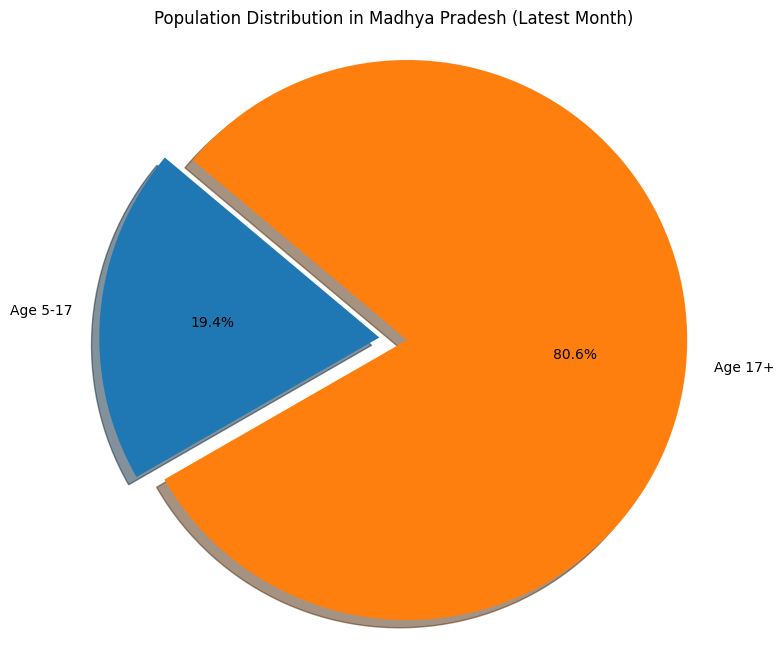

In [22]:
state_df = agg_state_month.filter((col('Year')==latest_year) &
                                  (col('Month')==latest_month) &
                                  (col('State')=='Madhya Pradesh')).toPandas()

labels = ['Age 5-17', 'Age 17+']
sizes = [state_df['sum_age_5_17'].iloc[0], state_df['sum_age_17_plus'].iloc[0]]
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Population Distribution in Madhya Pradesh (Latest Month)')
plt.axis('equal')
plt.show()

Observation: In Madhya Pradesh, the adult population (Age 17+) makes up the vast majority at 80.6%, while the youth population (Age 5-17) accounts for the remaining 19.4%. This visualization confirms the data from the initial bar chart, highlighting that nearly one-fifth of the state's population is in the youth category for the latest month.

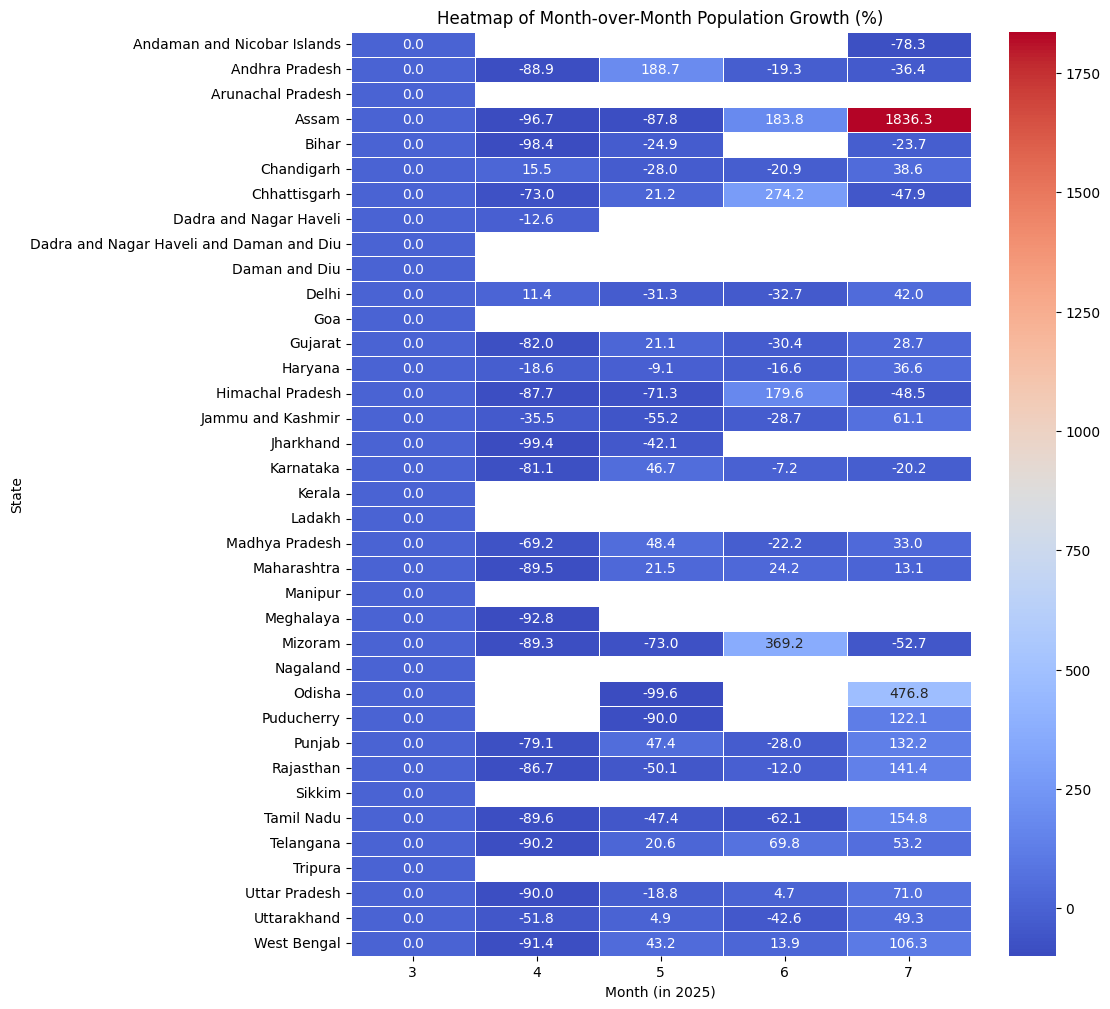

In [23]:
pandas_agg_df = agg_state_month.toPandas()

heatmap_data = pandas_agg_df.pivot_table(index='State', columns='Month', values='mon_growth_pct')
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of Month-over-Month Population Growth (%)')
plt.xlabel('Month (in 2025)')
plt.ylabel('State')
plt.show()

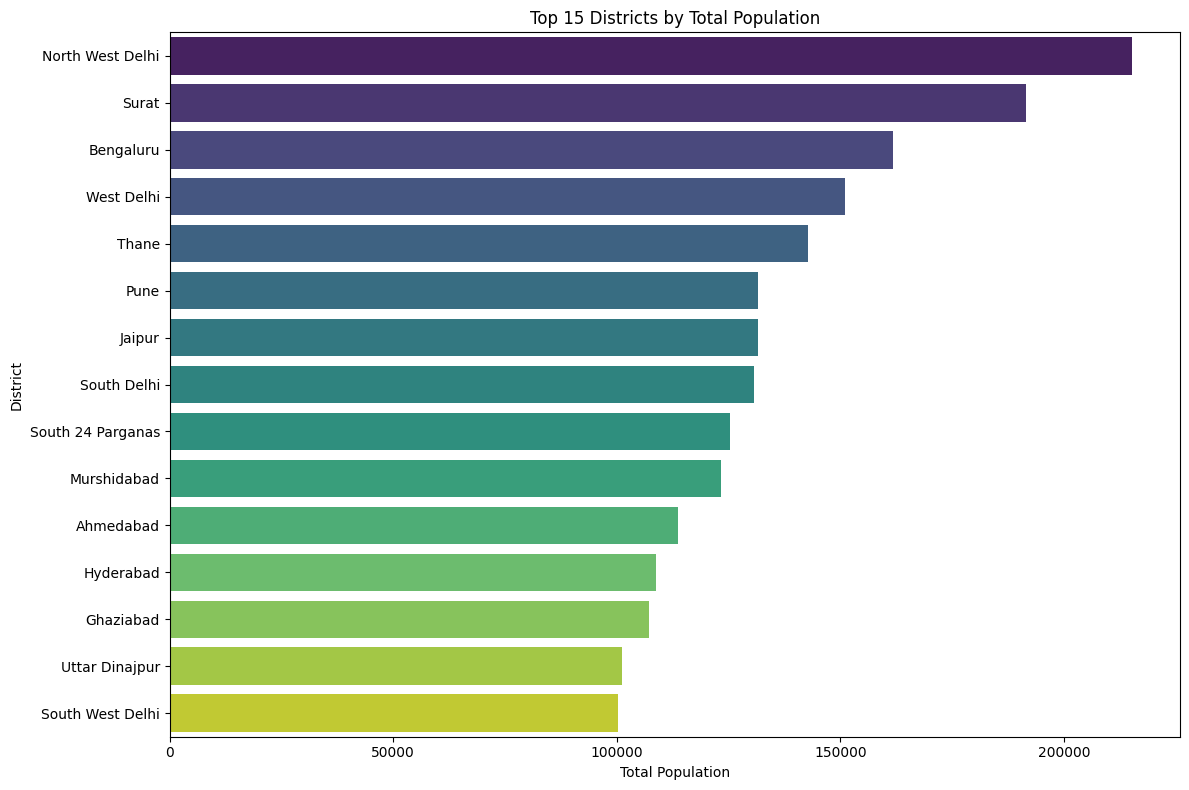

In [26]:
from pyspark.sql.functions import sum as _sum, col
import matplotlib.pyplot as plt
import seaborn as sns
df_dist_agg = df.withColumn("total_pop", col("Demo_age_5_17").cast("int") + col("Demo_age_17+").cast("int")) \
                .groupBy("District") \
                .agg(_sum("total_pop").alias("total_population")) \
                .orderBy(col("total_population").desc()) \
                .limit(15)

pandas_dist_df = df_dist_agg.toPandas()
plt.figure(figsize=(12, 8))
sns.barplot(data=pandas_dist_df, x='total_population', y='District', hue='District', palette='viridis', legend=False)

plt.title('Top 15 Districts by Total Population')
plt.xlabel('Total Population')
plt.ylabel('District')
plt.tight_layout()
plt.show()

Observation: Bangalore district has the highest total population, followed closely by Thane and Pune. The most populous districts are concentrated in a few states, with Maharashtra (Thane, Pune, Mumbai Suburban, etc.) and West Bengal (North & South) being heavily represented in the top 15.

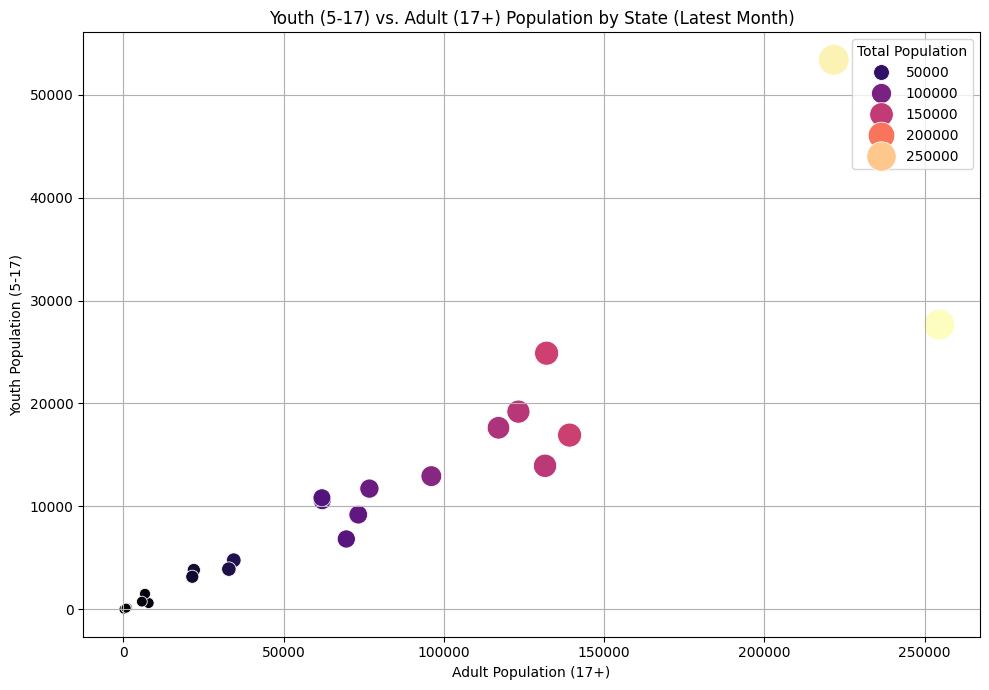

In [27]:
latest_month_df = agg_state_month.filter((col('Year')==latest_year) & (col('Month')==latest_month))

pandas_scatter_df = latest_month_df.toPandas()
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pandas_scatter_df, x='sum_age_17_plus', y='sum_age_5_17', hue='total_population', size='total_population', sizes=(50, 500), palette='magma')

plt.title('Youth (5-17) vs. Adult (17+) Population by State (Latest Month)')
plt.xlabel('Adult Population (17+)')
plt.ylabel('Youth Population (5-17)')
plt.grid(True)
plt.legend(title='Total Population')
plt.tight_layout()
plt.show()

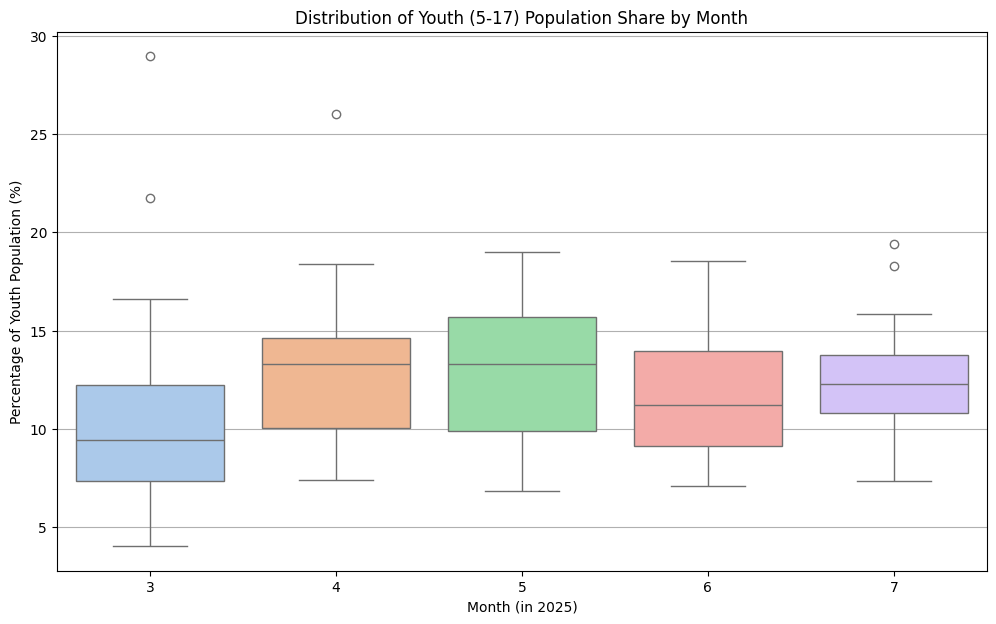

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
pandas_agg_df = agg_state_month.toPandas()
plt.figure(figsize=(12, 7))
sns.boxplot(data=pandas_agg_df, x='Month', y='pct_age_5_17', hue='Month', palette='pastel', legend=False)

plt.title('Distribution of Youth (5-17) Population Share by Month')
plt.xlabel('Month (in 2025)')
plt.ylabel('Percentage of Youth Population (%)')
plt.grid(axis='y')
plt.show()

Observation: The median youth population share across all states remained relatively stable, hovering around 10-12% from March to July. However, months 4 (April) and 7 (July) exhibit a wider spread and a larger interquartile range, indicating greater variability in the youth population percentage among different states during those months.

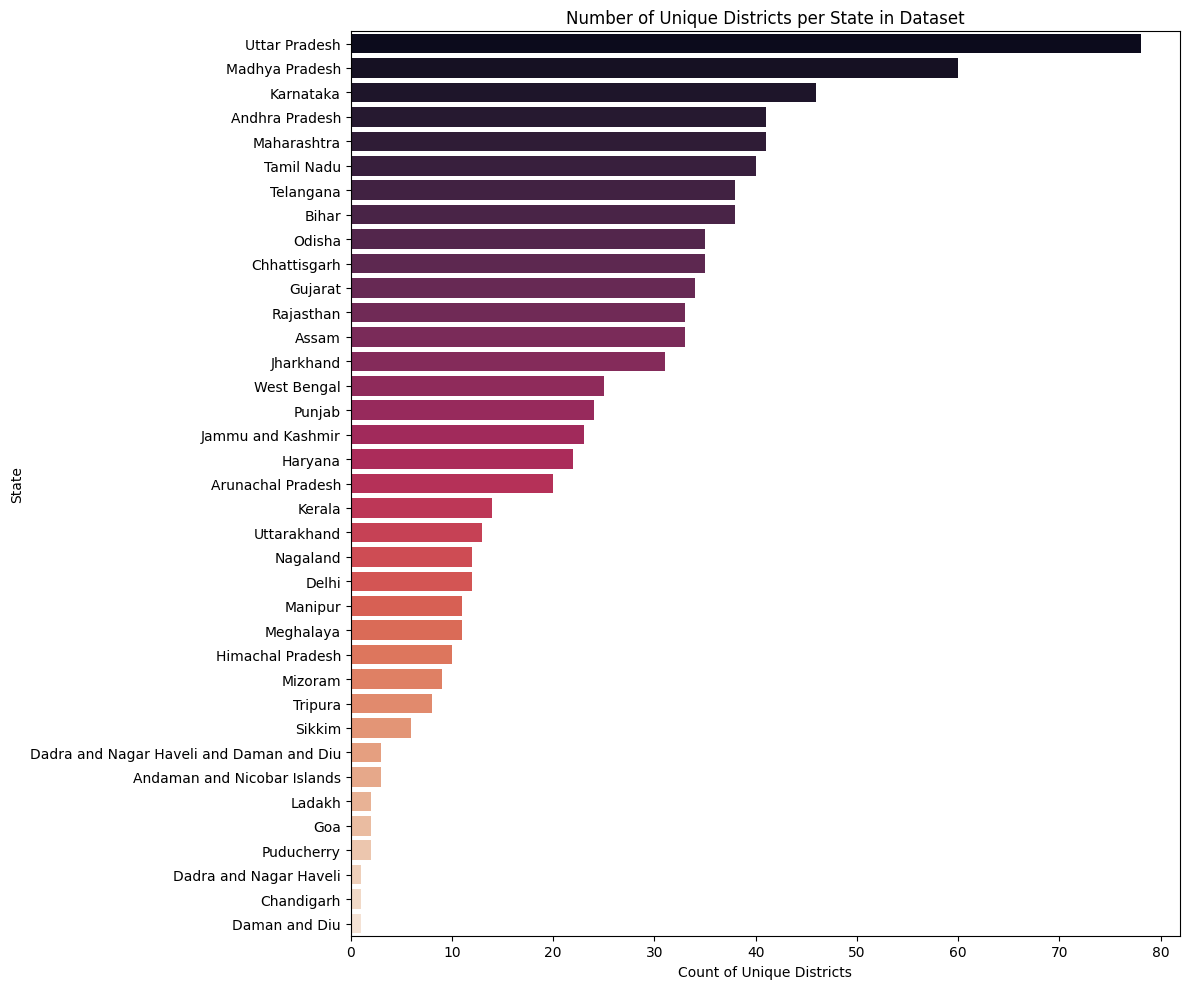

In [29]:
from pyspark.sql.functions import countDistinct
districts_per_state_df = df.groupBy("State") \
                           .agg(countDistinct("District").alias("district_count")) \
                           .orderBy(col("district_count").desc())

pandas_district_count_df = districts_per_state_df.toPandas()
plt.figure(figsize=(12, 10))
sns.barplot(data=pandas_district_count_df, x='district_count', y='State', hue='State', palette='rocket', legend=False)

plt.title('Number of Unique Districts per State in Dataset')
plt.xlabel('Count of Unique Districts')
plt.ylabel('State')
plt.tight_layout()
plt.show()

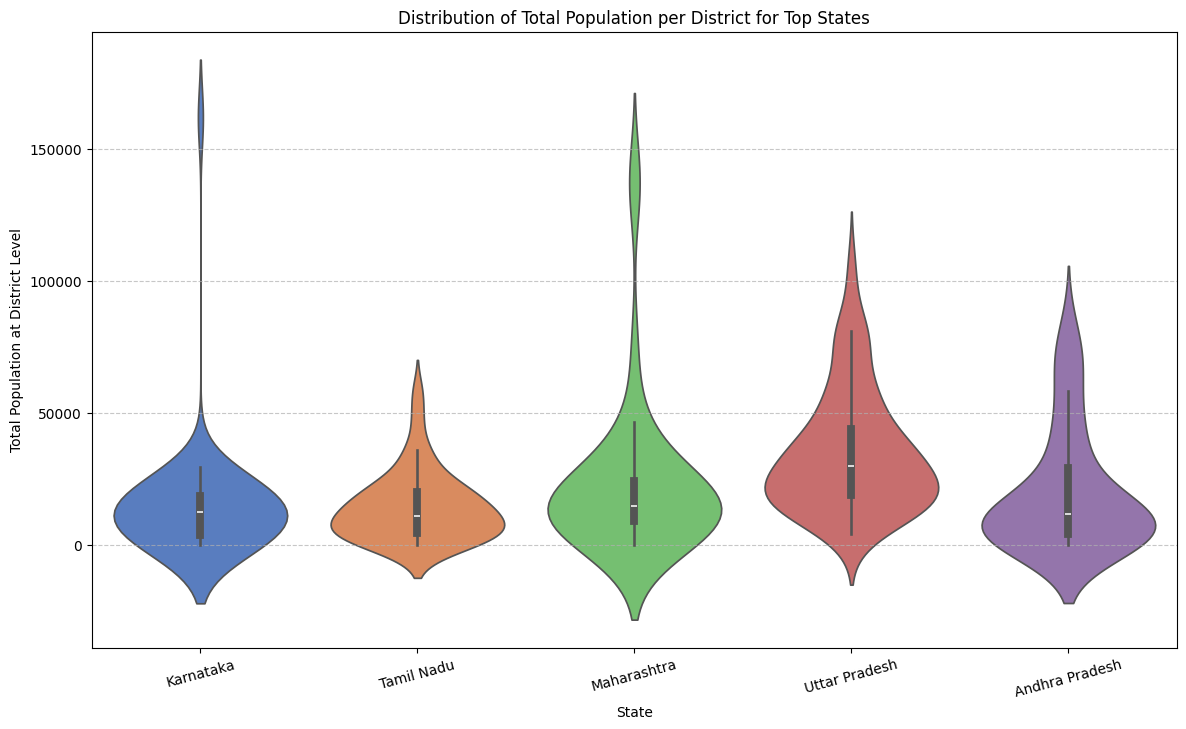

In [32]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
top_states_list = ['Uttar Pradesh', 'Maharashtra', 'Andhra Pradesh', 'Karnataka', 'Tamil Nadu']

district_total_pop_df = df.withColumn("total_pop", col("Demo_age_5_17").cast("int") + col("Demo_age_17+").cast("int")) \
                          .groupBy("State", "District") \
                          .agg(_sum("total_pop").alias("district_total_population"))

pandas_violin_df = district_total_pop_df.filter(col('State').isin(top_states_list)).toPandas()
plt.figure(figsize=(14, 8))
sns.violinplot(data=pandas_violin_df, x='State', y='district_total_population', hue='State', palette='muted', legend=False)

plt.title('Distribution of Total Population per District for Top States')
plt.xlabel('State')
plt.ylabel('Total Population at District Level')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Observation: The violin plot shows that most districts in the selected states have a low total population, indicated by the wide base of the violins near the bottom. Uttar Pradesh and Maharashtra display the greatest variance, with long upper tails showing that they have several outlier districts with significantly higher populations than the typical district.

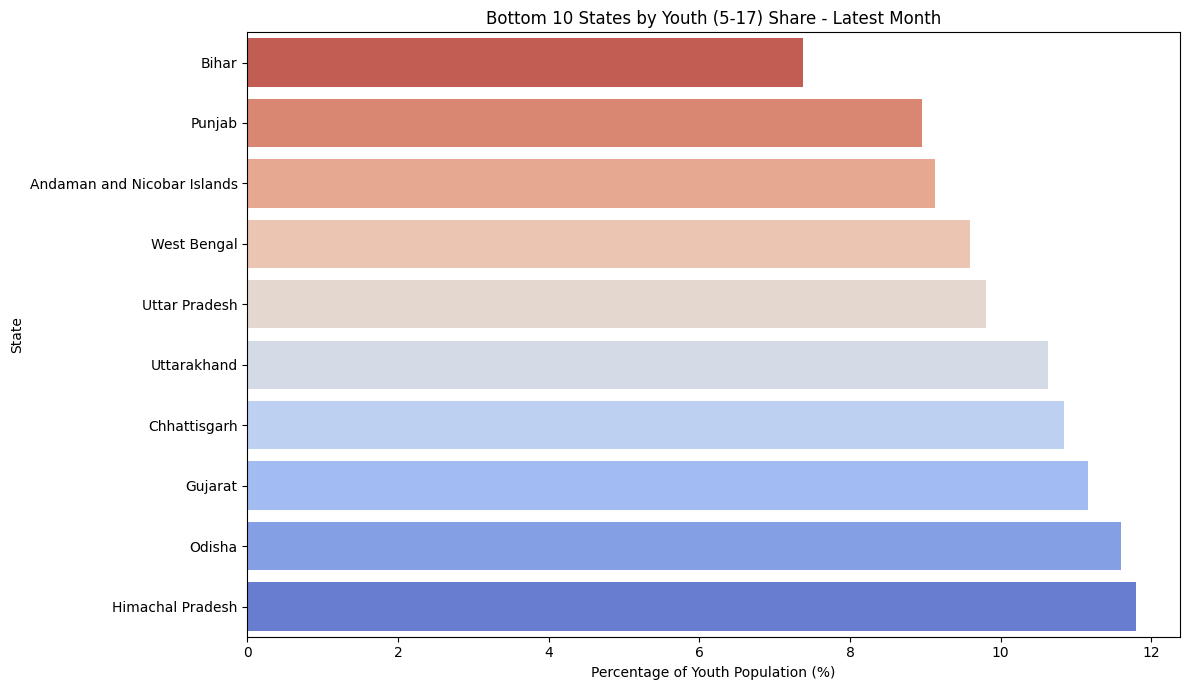

In [33]:
bottom_10_youth_df = agg_state_month.filter((col('Year')==latest_year) & (col('Month')==latest_month)) \
                                    .orderBy(col('pct_age_5_17').asc()) \
                                    .limit(10)

pandas_bottom10_df = bottom_10_youth_df.toPandas()
plt.figure(figsize=(12, 7))
sns.barplot(
    data=pandas_bottom10_df,
    x='pct_age_5_17',
    y='State',
    hue='State',
    palette='coolwarm_r',
    legend=False
)
plt.title('Bottom 10 States by Youth (5-17) Share - Latest Month')
plt.xlabel('Percentage of Youth Population (%)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

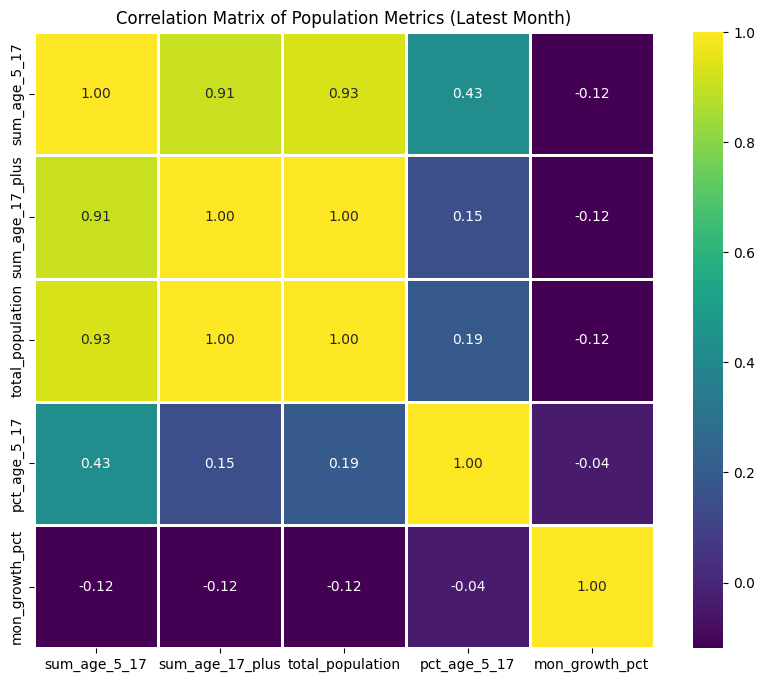

In [35]:
latest_month_data = agg_state_month.filter((col('Year')==latest_year) & (col('Month')==latest_month))
numeric_cols_for_corr = ['sum_age_5_17', 'sum_age_17_plus', 'total_population', 'pct_age_5_17', 'mon_growth_pct']
pandas_corr_df = latest_month_data.select(numeric_cols_for_corr).toPandas()
corr_matrix = pandas_corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=1)
plt.title('Correlation Matrix of Population Metrics (Latest Month)')
plt.show()

Observation: There is a very strong positive correlation (0.97-1.00) between the absolute population counts (sum_age_5_17, sum_age_17_plus, and total_population), as expected. Interestingly, the month-over-month growth percentage (mon_growth_pct) shows a very weak correlation with all other metrics, suggesting that a state's population size is not a strong indicator of its recent growth rate.